## Graph Attention Layer in Numpy

In [36]:
import numpy as np
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter
np.random.seed(0)


In [16]:
# Create a adjacency matrix for a 4-node graph
A = np.array([[1,1,1,1],
              [1,1,0,0],
              [1,0,1,1],
              [1,0,1,1]])
# Create a node feature matrix with 4 nodes and 4 features
X = np.random.uniform(-1, 1, (4, 4))
print("Adjacency Matrix:")
print(A)
print("Node Feature Matrix:")
print(X)

Adjacency Matrix:
[[1 1 1 1]
 [1 1 0 0]
 [1 0 1 1]
 [1 0 1 1]]
Node Feature Matrix:
[[-0.95956321  0.66523969  0.5563135   0.7400243 ]
 [ 0.95723668  0.59831713 -0.07704128  0.56105835]
 [-0.76345115  0.27984204 -0.71329343  0.88933783]
 [ 0.04369664 -0.17067612 -0.47088878  0.54846738]]


In [2]:
# Create a random weight matrix
W = np.random.uniform(-1, 1, (2, 4))
print("Weight Matrix:")
print(W)

Weight Matrix:
[[-0.95956321  0.66523969  0.5563135   0.7400243 ]
 [ 0.95723668  0.59831713 -0.07704128  0.56105835]]


In [3]:
# Create a random attention weight matrix
W_att = np.random.uniform(-1, 1, (1, 4))
print("Attention Weight Matrix:")
print(W_att)

Attention Weight Matrix:
[[-0.76345115  0.27984204 -0.71329343  0.88933783]]


In [4]:
# Find hidden vectors in adjacency matrix in COO fomart
connections = np.where(A>0)
print("Connections (i, j) where A[i][j] > 0:")
print(connections)

Connections (i, j) where A[i][j] > 0:
(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))


In [5]:
np.concatenate([(X@W.T)[connections[0]], (X@W.T)[connections[1]]], axis=1)

array([[ 0.37339233,  0.38548525,  0.37339233,  0.38548525],
       [ 0.37339233,  0.38548525,  0.85102612,  0.47765279],
       [ 0.37339233,  0.38548525, -0.67755906,  0.73566587],
       [ 0.37339233,  0.38548525, -0.65268413,  0.24235977],
       [ 0.85102612,  0.47765279,  0.37339233,  0.38548525],
       [ 0.85102612,  0.47765279,  0.85102612,  0.47765279],
       [-0.67755906,  0.73566587,  0.37339233,  0.38548525],
       [-0.67755906,  0.73566587, -0.67755906,  0.73566587],
       [-0.67755906,  0.73566587, -0.65268413,  0.24235977],
       [-0.65268413,  0.24235977,  0.37339233,  0.38548525],
       [-0.65268413,  0.24235977, -0.67755906,  0.73566587],
       [-0.65268413,  0.24235977, -0.65268413,  0.24235977]])

In [6]:
a = W_att @ np.concatenate([(X@W.T)[connections[0]], (X@W.T)[connections[1]]], axis=1).T
print(a)

[[-0.1007035  -0.35942847  0.96036209  0.50390318 -0.43956122 -0.69828618
   0.79964181  1.8607074   1.40424849  0.64260322  1.70366881  1.2472099 ]]


In [7]:
def leaky_relu(x, alpha=0.2):
    return np.maximum(alpha*x,x)

e = leaky_relu(a)
print(e)

[[-0.0201407  -0.07188569  0.96036209  0.50390318 -0.08791224 -0.13965724
   0.79964181  1.8607074   1.40424849  0.64260322  1.70366881  1.2472099 ]]


In [8]:
E = np.zeros(A.shape)

E[connections[0], connections[1]] = e[0]
print(E)

[[-0.0201407  -0.07188569  0.96036209  0.50390318]
 [-0.08791224 -0.13965724  0.          0.        ]
 [ 0.79964181  0.          1.8607074   1.40424849]
 [ 0.64260322  0.          1.70366881  1.2472099 ]]


In [9]:
def softmax(x, axis):
    e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis=axis))
    sum = np.expand_dims(np.sum(e, axis=axis), axis=axis)
    return e / sum
# Calculate the attention scores matrix
W_alpha = softmax(E, axis=1)
print(W_alpha)

[[0.15862414 0.15062488 0.42285965 0.26789133]
 [0.24193418 0.22973368 0.26416607 0.26416607]
 [0.16208847 0.07285714 0.46834625 0.29670814]
 [0.16010498 0.08420266 0.46261506 0.2930773 ]]


In [11]:
# Calculate the embedding matrix H
H = A.T @ W_alpha @ X @ W.T
print(H)

[[-1.10126376  1.99749693]
 [-0.33950544  0.97045933]
 [-1.03570438  1.53614075]
 [-1.03570438  1.53614075]]


## Implementing GAT IN Pytorch Geometric

In [ ]:


cora_dataset = Planetoid(root='../data/Cora', name='Cora')
cora_dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [26]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    
    def accuracy(self, pred, labels):
        return torch.sum(pred == labels)/len(labels)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs):
            
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                train_acc = self.accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
                val_acc = self.accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch>3} | Train Loss {loss.item():.4f} | Train Acc {train_acc*100:.3f} | '
                      f'Val Loss {criterion(out[data.val_mask], data.y[data.val_mask]):.4f} | Val Acc {val_acc*100:.2f} | ')
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        test_loss = F.cross_entropy(out[data.test_mask], data.y[data.test_mask])
        test_acc = self.accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        print(f'Test Loss {test_loss:.4f} | Test Acc {test_acc:.4f} | ')
        return test_loss, test_acc

In [34]:
gat = GAT(cora_dataset.num_features, 32, cora_dataset.num_classes, heads=8)
print(gat)
gat.fit(cora_dataset[0], 200)
test_acc = gat.test(cora_dataset[0])
print(f'GAT Test Accuracy on Cora Dataset: {test_acc[1]*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch False | Train Loss 1.9817 | Train Acc 9.286 | Val Loss 1.9474 | Val Acc 14.40 | 
Epoch True | Train Loss 0.0418 | Train Acc 97.857 | Val Loss 1.6640 | Val Acc 70.40 | 
Epoch True | Train Loss 0.0206 | Train Acc 98.571 | Val Loss 1.5144 | Val Acc 71.20 | 
Epoch True | Train Loss 0.0229 | Train Acc 99.286 | Val Loss 1.3005 | Val Acc 69.40 | 
Epoch True | Train Loss 0.0138 | Train Acc 100.000 | Val Loss 1.2959 | Val Acc 71.60 | 
Epoch True | Train Loss 0.0171 | Train Acc 99.286 | Val Loss 1.2659 | Val Acc 72.60 | 
Epoch True | Train Loss 0.0104 | Train Acc 100.000 | Val Loss 1.3657 | Val Acc 70.40 | 
Epoch True | Train Loss 0.0467 | Train Acc 99.286 | Val Loss 1.4618 | Val Acc 68.60 | 
Epoch True | Train Loss 0.0259 | Train Acc 98.571 | Val Loss 1.3367 | Val Acc 70.80 | 
Epoch True | Train Loss 0.0256 | Train Acc 98.571 | Val Loss 1.4187 | Val Acc 70.80 | 
Test Loss 0.7994 | Test Acc 0.8000 | 
GAT Tes

Text(0, 0.5, 'Number of Nodes')

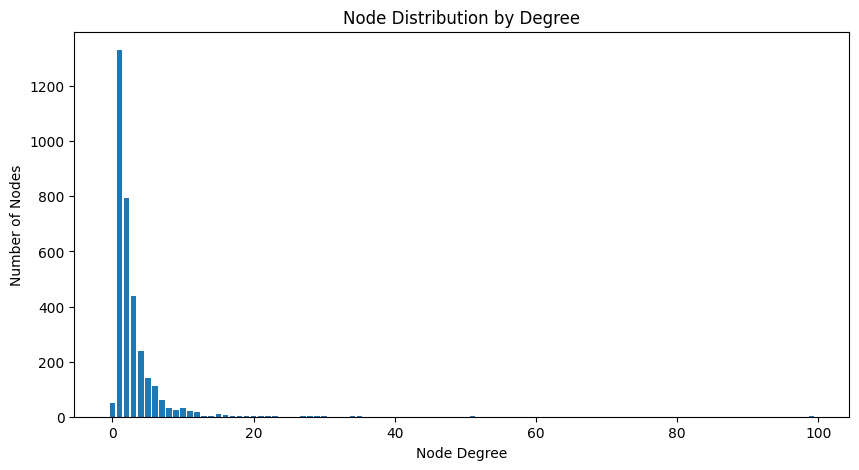

In [ ]:
citeseer_dataset = Planetoid(root='../data/Citeseer', name='Citeseer')
degrees = degree(citeseer_dataset[0].edge_index[0]).numpy()
plt.figure(figsize=(10, 5))
numbers = Counter(degrees)  
plt.bar(numbers.keys(), numbers.values())
plt.title('Node Distribution by Degree')
plt.xlabel('Node Degree')
plt.ylabel('Number of Nodes')

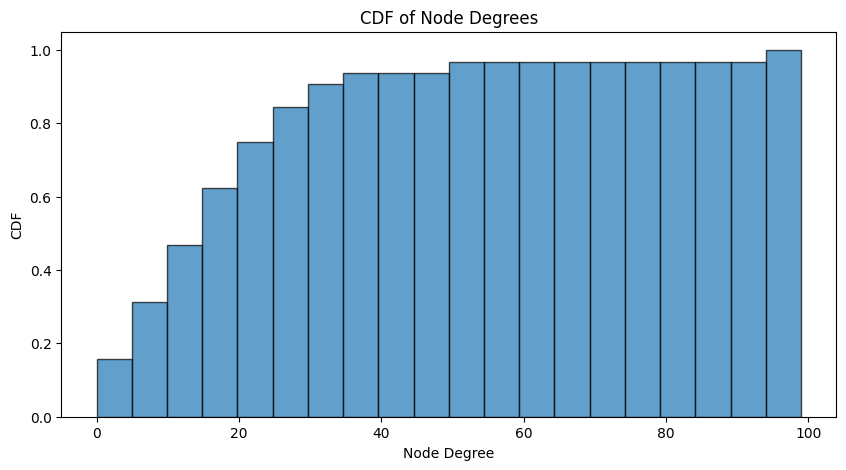

In [47]:
plt.figure(figsize=(10, 5))
numbers = Counter(degrees)  
plt.hist(numbers.keys(), cumulative=True, bins=20, density=True, edgecolor='black', alpha=0.7)
plt.title('CDF of Node Degrees')
plt.xlabel('Node Degree')
plt.ylabel('CDF')
plt.show()

In [41]:
gat_citeseer = GAT(citeseer_dataset.num_features, 16, citeseer_dataset.num_classes, heads=8)
print(gat_citeseer)
gat_citeseer.fit(citeseer_dataset[0], 100)
test_acc_citeseer = gat_citeseer.test(citeseer_dataset[0])
print(f'GAT Test Accuracy on Citeseer Dataset: {test_acc_citeseer[1]*100:.2f}%')


GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)
Epoch False | Train Loss 1.8067 | Train Acc 13.333 | Val Loss 1.7988 | Val Acc 16.80 | 
Epoch True | Train Loss 0.0192 | Train Acc 99.167 | Val Loss 2.0237 | Val Acc 57.80 | 
Epoch True | Train Loss 0.0080 | Train Acc 100.000 | Val Loss 1.7646 | Val Acc 63.00 | 
Epoch True | Train Loss 0.0110 | Train Acc 100.000 | Val Loss 1.7439 | Val Acc 62.20 | 
Epoch True | Train Loss 0.0156 | Train Acc 100.000 | Val Loss 1.8217 | Val Acc 61.20 | 
Test Loss 1.3329 | Test Acc 0.6610 | 
GAT Test Accuracy on Citeseer Dataset: 66.10%


Text(0, 0.5, 'Accuracy')

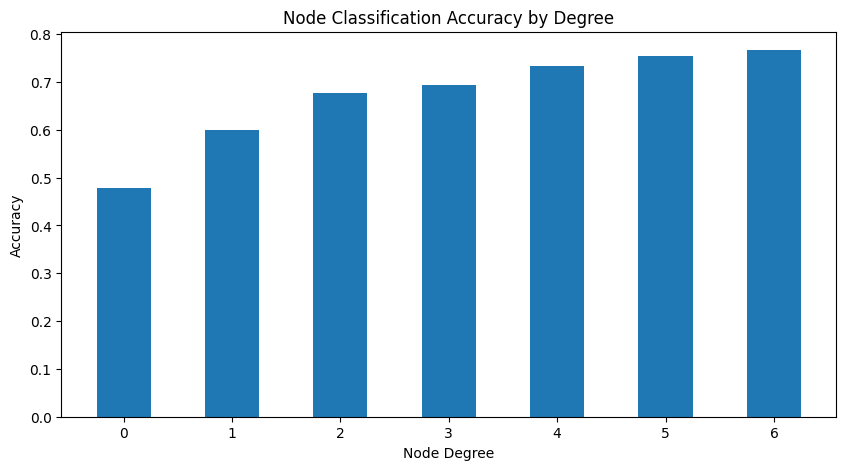

In [44]:
outp = gat_citeseer(citeseer_dataset[0].x, citeseer_dataset[0].edge_index)

degrees = degree(citeseer_dataset[0].edge_index[0]).numpy()
accuracies = []
sizes = []
for i in range(0,6):
    mask = np.where(degrees == i)[0]

    accuracies.append(gat_citeseer.accuracy(outp[mask].argmax(dim=1), citeseer_dataset[0].y[mask]))
    sizes.append(len(mask))

mask = np.where(degrees >5)[0]

accuracies.append(gat_citeseer.accuracy(outp[mask].argmax(dim=1), citeseer_dataset[0].y[mask]))
sizes.append(len(mask))

plt.figure(figsize=(10, 5))
plt.bar(np.arange(0,7), accuracies, width=0.5)
plt.title('Node Classification Accuracy by Degree')
plt.xlabel('Node Degree')
plt.ylabel('Accuracy')